In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [2]:
import keras
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten, LSTM, Conv1D, MaxPool1D, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import np_utils 
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import sequence
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [3]:
img=mpimg.imread('Img/big_green.png')

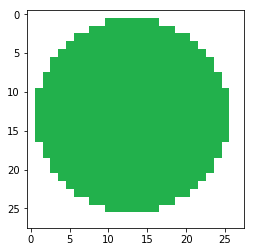

In [4]:
imgplot = plt.imshow(img)

In [5]:
img.shape

(28, 28, 3)

In [6]:
img.flatten()

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [5]:
img=mpimg.imread('Img/big_green.png').flatten()
data = pd.DataFrame({"x{}".format(i): [img[i]] for i in range(img.shape[0])})
img=mpimg.imread('Img/small_green.png').flatten()
data = data.append(pd.DataFrame({"x{}".format(i): [img[i]] for i in range(img.shape[0])}))
img=mpimg.imread('Img/big_red.png').flatten()
data = data.append(pd.DataFrame({"x{}".format(i): [img[i]] for i in range(img.shape[0])}))
img=mpimg.imread('Img/small_red.png').flatten()
data = data.append(pd.DataFrame({"x{}".format(i): [img[i]] for i in range(img.shape[0])}))

In [6]:
data = data.reset_index(drop=True)
data

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x2342,x2343,x2344,x2345,x2346,x2347,x2348,x2349,x2350,x2351
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [24]:
y = pd.DataFrame({"Group": [1, 1, 0, 0]})

## Individual trials

In [43]:
def trial_intra(data):
    inputs = Input(shape=(2352,))
    preds = Dense(1, activation="sigmoid")(inputs)

    model = Model(inputs=inputs, outputs=preds)
    sgd = keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

    # Green 1, Red 0
    y = pd.DataFrame({"Group": [1, 1, 0, 0]})
    trials_rule1 = 0
    trials_rule2 = 0
    switch = False
    c = 0
    
    while True:
        model.fit(data, y, batch_size=1, verbose=0)
        acc = model.history.history["acc"][0]
        
        if acc == 1:
            c += 1
        else:
            c = 0
            
        if switch:
            trials_rule2 += 1
        else:
            trials_rule1 += 1
            
        if (c == 8) and not(switch):
            y = pd.DataFrame({"Group": [0, 0, 1, 1]})
            switch = True
            c = 0
            
        if (c == 8) and switch:
            return trials_rule1, trials_rule2

In [53]:
trial_intra(data)

(11, 17)

In [54]:
def trial_inter(data):
    inputs = Input(shape=(2352,))
    preds = Dense(1, activation="sigmoid")(inputs)

    model = Model(inputs=inputs, outputs=preds)
    sgd = keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

    # Green 1, Red 0
    y = pd.DataFrame({"Group": [1, 1, 0, 0]})
    trials_rule1 = 0
    trials_rule2 = 0
    switch = False
    c = 0
    
    while True:
        model.fit(data, y, batch_size=1, verbose=0)
        acc = model.history.history["acc"][0]
        
        if acc == 1:
            c += 1
        else:
            c = 0
            
        if switch:
            trials_rule2 += 1
        else:
            trials_rule1 += 1
            
        if (c == 8) and not(switch):
            y = pd.DataFrame({"Group": [1, 0, 1, 0]})
            switch = True
            c = 0
            
        if (c == 8) and switch:
            return trials_rule1, trials_rule2

In [66]:
trial_inter(data)

(15, 15)

## Automated

In [35]:
circles = ["big green", "small green", "big red", "small red"]

In [36]:
first = np.random.choice(circles)
first

'big red'

In [37]:
circles.remove(first)

In [38]:
circles

['big green', 'small green', 'small red']

In [39]:
for x in circles:
    if (first.split()[0] not in x) and (first.split()[1] not in x):
        circles.remove(x)

In [40]:
circles

['big green', 'small red']

In [41]:
second = np.random.choice(circles)
circles.remove(second)
first, second

('big red', 'big green')

In [42]:
inter = np.random.randint(0,2)
if inter:
    if first.split()[0] == second.split()[0]:
        new_positive = (first, second)[np.random.randint(0,2)].split()[1]
    else:
        new_positive = (first, second)[np.random.randint(0,2)].split()[0]
else:
    if first.split()[0] == second.split()[0]:
        new_positive = circles[0].split()[0]
    else:
        new_positive = circles[0].split()[1]

In [43]:
inter

0

In [44]:
new_positive

'small'

In [45]:
circles = ["big green", "small green", "big red", "small red"]

In [46]:
i = 0
while i < len(circles):
    if new_positive not in circles[i]:
        del circles[i]
    else:
        i += 1

In [47]:
circles

['small green', 'small red']

In [25]:
circles_dict = {
    "big green": 0,
    "small green": 1,
    "big red": 2,
    "small red": 3
}

In [57]:
def trial(data, circles_dict):
    # Define model
    inputs = Input(shape=(2352,))
    preds = Dense(1, activation="sigmoid")(inputs)
    model = Model(inputs=inputs, outputs=preds)
    sgd = keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    
    # For plot
    acc_list = []

    # Decide phase 1 rule
    circles = ["big green", "small green", "big red", "small red"]
    first = np.random.choice(circles)
    circles.remove(first)
    
    for x in circles:
        if (first.split()[0] not in x) and (first.split()[1] not in x):
            circles.remove(x)
            
    second = np.random.choice(circles)
    circles.remove(second)
    rule1 = []
    
    for key in circles_dict.keys():
        if (key == first) or (key == second):
            rule1.append(1)
        else:
            rule1.append(0)
            
    y = pd.DataFrame({"Group": rule1})
    
    # Decide phase 2 rule
    switch_type = np.random.choice(["inter", "intra"])
    
    if switch_type == "inter":
        if first.split()[0] == second.split()[0]:
            new_positive = (first, second)[np.random.randint(0,2)].split()[1]
        else:
            new_positive = (first, second)[np.random.randint(0,2)].split()[0]
    else:
        if first.split()[0] == second.split()[0]:
            new_positive = circles[0].split()[0]
        else:
            new_positive = circles[0].split()[1]
            
    circles = ["big green", "small green", "big red", "small red"]
    i = 0
    
    while i < len(circles):
        if new_positive not in circles[i]:
            del circles[i]
        else:
            i += 1
            
    rule2 = []
    
    for key in circles_dict.keys():
        if (key == circles[0]) or (key == circles[1]):
            rule2.append(1)
        else:
            rule2.append(0)
    
    # Initialize variables
    trials_rule1 = 0
    trials_rule2 = 0
    switch = False
    c = 0
    
    while True:
        model.fit(data, y, batch_size=1, verbose=0)
        acc = model.history.history["acc"][0]
        acc_list.append(acc)
        
        if acc == 1:
            c += 1
        else:
            c = 0
            
        if switch:
            trials_rule2 += 1
        else:
            trials_rule1 += 1
            
        if (c == 8) and not(switch):
            y = pd.DataFrame({"Group": rule2})
            switch = True
            c = 0
            
        if (c == 8) and switch:
            plt.figure(figsize=(10,6))
            plt.plot(acc_list, color=(74/255, 136/255, 144/255), linewidth=2)
            plt.ylabel("Proporción de aciertos", fontdict = {'fontsize': 20})
            plt.xlabel("Número de ensayos", fontdict = {'fontsize': 20})
            plt.title("Curva de aprendizaje", fontdict = {'fontsize': 30})
            return trials_rule1, trials_rule2, switch_type

(13, 15, 'inter')

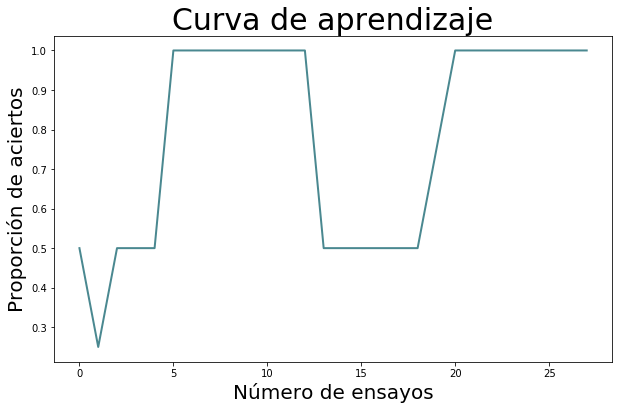

In [65]:
trial(data, circles_dict)

In [7]:
def experiment(file, trials, data, circles_dict):
    try:
        results = pd.read_pickle(file)
    except:
        results = pd.DataFrame()
    
    for i in tqdm(range(trials)):
        trials_rule1, trials_rule2, switch_type = trial(data, circles_dict)
        results = results.append(pd.DataFrame({"Trials_rule1": [trials_rule1], 
                                               "Trials_rule2": [trials_rule2], 
                                               "Switch_type": [switch_type]}))
        results.to_pickle(file)

In [12]:
experiment("results.pkl", 8, data, circles_dict)

In [13]:
a = pd.read_pickle("results.pkl")

In [14]:
a.shape

(600, 3)

In [15]:
a.tail()

,Trials_rule1,Trials_rule2,Switch_type
0,12,18,intra
0,12,14,inter
0,14,18,intra
0,12,17,intra
0,11,14,inter


In [34]:
y = pd.DataFrame({"Group": [1, 0, 1, 0]})

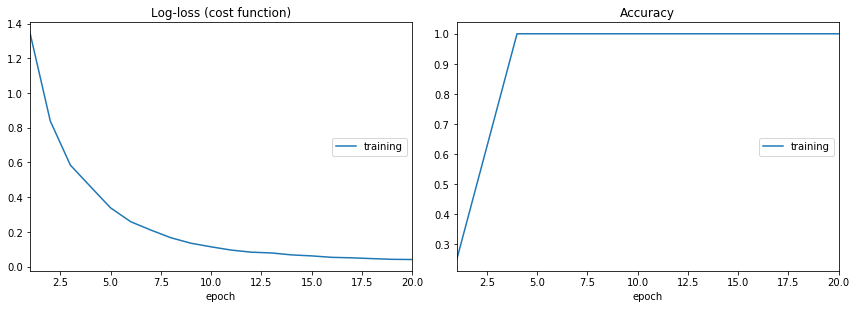

Log-loss (cost function):
training   (min:    0.041, max:    1.341, cur:    0.041)

Accuracy:
training   (min:    0.250, max:    1.000, cur:    1.000)


In [35]:
inputs = Input(shape=(2352,))
preds = Dense(1, activation="sigmoid")(inputs)
model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(data, y, batch_size=1, epochs=20, verbose=0,
                    callbacks=[PlotLossesKeras()])

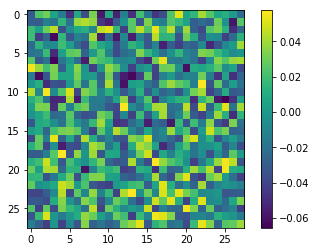

In [42]:
plt.imshow(model.get_weights()[0][28*28*2:3*28*28,0].reshape(28, 28))
plt.colorbar()

## Adding hidden layer

In [943]:
def trial_intra(data):
    inputs = Input(shape=(2352,))
    hidden = Dense(4, activation="relu", kernel_regularizer=l2(1))(inputs)
    preds = Dense(1, activation="sigmoid")(hidden)

    model = Model(inputs=inputs, outputs=preds)
    sgd = keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

    # Green 1, Red 0
    y = pd.DataFrame({"Group": [1, 1, 0, 0]})
    trials_rule1 = 0
    trials_rule2 = 0
    switch = False
    c = 0
    
    while True:
        model.fit(data, y, batch_size=1, verbose=0)
        acc = model.history.history["acc"][0]
        
        if acc == 1:
            c += 1
        else:
            c = 0
            
        if switch:
            trials_rule2 += 1
        else:
            trials_rule1 += 1
            
        if (c == 8) and not(switch):
            y = pd.DataFrame({"Group": [0, 0, 1, 1]})
            switch = True
            c = 0
            
        if (c == 8) and switch:
            return trials_rule1, trials_rule2

In [949]:
trial_intra(data)

(168, 397)

In [719]:
inputs = Input(shape=(2352,))
hidden = Dense(4, activation="relu", kernel_regularizer=l2(1))(inputs)
preds = Dense(1, activation="sigmoid")(hidden)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [720]:
y = pd.DataFrame({"Group": [1, 1, 0, 0]})

In [748]:
model.fit(data, y, batch_size=1)

Epoch 1/1
4/4 [==============================] - ETA: 0s - loss: 5.0380 - acc: 1.000 - 0s 5ms/step - loss: 5.3008 - acc: 1.0000


In [749]:
y = pd.DataFrame({"Group": [0, 0, 1, 1]})

In [942]:
model.fit(data, y, batch_size=1)

Epoch 1/1
4/4 [==============================] - ETA: 0s - loss: 1.0178 - acc: 1.000 - 0s 5ms/step - loss: 1.0178 - acc: 0.5000


In [950]:
def trial_inter(data):
    inputs = Input(shape=(2352,))
    hidden = Dense(4, activation="relu", kernel_regularizer=l2(1))(inputs)
    preds = Dense(1, activation="sigmoid")(hidden)

    model = Model(inputs=inputs, outputs=preds)
    sgd = keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

    # Green 1, Red 0
    y = pd.DataFrame({"Group": [1, 1, 0, 0]})
    trials_rule1 = 0
    trials_rule2 = 0
    switch = False
    c = 0
    
    while True:
        model.fit(data, y, batch_size=1, verbose=0)
        acc = model.history.history["acc"][0]
        
        if acc == 1:
            c += 1
        else:
            c = 0
            
        if switch:
            trials_rule2 += 1
        else:
            trials_rule1 += 1
            
        if (c == 8) and not(switch):
            y = pd.DataFrame({"Group": [1, 0, 1, 0]})
            switch = True
            c = 0
            
        if (c == 8) and switch:
            return trials_rule1, trials_rule2

In [957]:
trial_inter(data)

(11, 21)

In [958]:
circles_dict = {
    "big green": 0,
    "small green": 1,
    "big red": 2,
    "small red": 3
}

In [966]:
def trial(data, circles_dict):
    # Define model
    inputs = Input(shape=(2352,))
    hidden = Dense(4, activation="relu", kernel_regularizer=l2(1))(inputs)
    preds = Dense(1, activation="sigmoid")(hidden)

    model = Model(inputs=inputs, outputs=preds)
    sgd = keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

    # Decide phase 1 rule
    circles = ["big green", "small green", "big red", "small red"]
    first = np.random.choice(circles)
    circles.remove(first)
    
    for x in circles:
        if (first.split()[0] not in x) and (first.split()[1] not in x):
            circles.remove(x)
            
    second = np.random.choice(circles)
    circles.remove(second)
    rule1 = []
    
    for key in circles_dict.keys():
        if (key == first) or (key == second):
            rule1.append(1)
        else:
            rule1.append(0)
            
    y = pd.DataFrame({"Group": rule1})
    
    # Decide phase 2 rule
    switch_type = np.random.choice(["inter", "intra"])
    
    if switch_type == "inter":
        if first.split()[0] == second.split()[0]:
            new_positive = (first, second)[np.random.randint(0,2)].split()[1]
        else:
            new_positive = (first, second)[np.random.randint(0,2)].split()[0]
    else:
        if first.split()[0] == second.split()[0]:
            new_positive = circles[0].split()[0]
        else:
            new_positive = circles[0].split()[1]
            
    circles = ["big green", "small green", "big red", "small red"]
    i = 0
    
    while i < len(circles):
        if new_positive not in circles[i]:
            del circles[i]
        else:
            i += 1
            
    rule2 = []
    
    for key in circles_dict.keys():
        if (key == circles[0]) or (key == circles[1]):
            rule2.append(1)
        else:
            rule2.append(0)
    
    # Initialize variables
    trials_rule1 = 0
    trials_rule2 = 0
    switch = False
    c = 0
    
    while True:
        model.fit(data, y, batch_size=1, verbose=0)
        acc = model.history.history["acc"][0]
        
        if acc == 1:
            c += 1
        else:
            c = 0
            
        if switch:
            trials_rule2 += 1
        else:
            trials_rule1 += 1
            
        if (c == 8) and not(switch):
            y = pd.DataFrame({"Group": rule2})
            switch = True
            c = 0
            
        if (c == 8) and switch:
            return trials_rule1, trials_rule2, switch_type
        
        if trials_rule2 >= 500:
            return [None]*3

In [967]:
def experiment(file, trials, data, circles_dict):
    try:
        results = pd.read_pickle(file)
    except:
        results = pd.DataFrame()
    
    for i in tqdm(range(trials)):
        trials_rule1, trials_rule2, switch_type = trial(data, circles_dict)
        results = results.append(pd.DataFrame({"Trials_rule1": [trials_rule1], 
                                               "Trials_rule2": [trials_rule2], 
                                               "Switch_type": [switch_type]}))
        results.to_pickle(file)

In [973]:
experiment("results-hidden.pkl", 15, data, circles_dict)

In [974]:
a = pd.read_pickle("results-hidden.pkl")

In [975]:
a.shape

(100, 3)

## Dropout distractor

In [1027]:
inputs = Input(shape=(2352,))
dropout = Dropout(0.5)(inputs)
hidden = Dense(4, activation="relu", kernel_regularizer=l2(1))(dropout)
preds = Dense(1, activation="sigmoid")(hidden)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [1028]:
y = pd.DataFrame({"Group": [1, 1, 0, 0]})

In [1052]:
model.fit(data, y, batch_size=1)

Epoch 1/1
4/4 [==============================] - ETA: 0s - loss: 6.6974 - acc: 1.000 - 0s 14ms/step - loss: 7.3137 - acc: 0.5000


In [1053]:
y = pd.DataFrame({"Group": [0, 0, 1, 1]})

In [1130]:
model.fit(data, y, batch_size=1)

Epoch 1/1
4/4 [==============================] - ETA: 0s - loss: 4.0380 - acc: 1.000 - 0s 16ms/step - loss: 4.4142 - acc: 0.7500


In [1024]:
def trial(data, circles_dict):
    # Define model
    inputs = Input(shape=(2352,))
    dropout = Dropout(0.5)(inputs)
    preds = Dense(1, activation="sigmoid")(dropout)

    model = Model(inputs=inputs, outputs=preds)
    sgd = keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

    # Decide phase 1 rule
    circles = ["big green", "small green", "big red", "small red"]
    first = np.random.choice(circles)
    circles.remove(first)
    
    for x in circles:
        if (first.split()[0] not in x) and (first.split()[1] not in x):
            circles.remove(x)
            
    second = np.random.choice(circles)
    circles.remove(second)
    rule1 = []
    
    for key in circles_dict.keys():
        if (key == first) or (key == second):
            rule1.append(1)
        else:
            rule1.append(0)
            
    y = pd.DataFrame({"Group": rule1})
    
    # Decide phase 2 rule
    switch_type = np.random.choice(["inter", "intra"])
    
    if switch_type == "inter":
        if first.split()[0] == second.split()[0]:
            new_positive = (first, second)[np.random.randint(0,2)].split()[1]
        else:
            new_positive = (first, second)[np.random.randint(0,2)].split()[0]
    else:
        if first.split()[0] == second.split()[0]:
            new_positive = circles[0].split()[0]
        else:
            new_positive = circles[0].split()[1]
            
    circles = ["big green", "small green", "big red", "small red"]
    i = 0
    
    while i < len(circles):
        if new_positive not in circles[i]:
            del circles[i]
        else:
            i += 1
            
    rule2 = []
    
    for key in circles_dict.keys():
        if (key == circles[0]) or (key == circles[1]):
            rule2.append(1)
        else:
            rule2.append(0)
    
    # Initialize variables
    trials_rule1 = 0
    trials_rule2 = 0
    switch = False
    c = 0
    
    while True:
        model.fit(data, y, batch_size=1, verbose=0)
        acc = model.history.history["acc"][0]
        
        if acc == 1:
            c += 1
        else:
            c = 0
            
        if switch:
            trials_rule2 += 1
        else:
            trials_rule1 += 1
            
        if (c == 8) and not(switch):
            y = pd.DataFrame({"Group": rule2})
            switch = True
            c = 0
            
        if (c == 8) and switch:
            return trials_rule1, trials_rule2, switch_type
        
        if trials_rule2 >= 500:
            return [None]*3

In [1025]:
def experiment(file, trials, data, circles_dict):
    try:
        results = pd.read_pickle(file)
    except:
        results = pd.DataFrame()
    
    for i in tqdm(range(trials)):
        trials_rule1, trials_rule2, switch_type = trial(data, circles_dict)
        results = results.append(pd.DataFrame({"Trials_rule1": [trials_rule1], 
                                               "Trials_rule2": [trials_rule2], 
                                               "Switch_type": [switch_type]}))
        results.to_pickle(file)

In [1026]:
results = experiment("results-distractor.pkl", 100, data, circles_dict)

## Looking for hypothesis testing

In [1148]:
def trial(data, circles_dict):
    # Define model
    inputs = Input(shape=(2352,))
    preds = Dense(1, activation="sigmoid")(inputs)
    model = Model(inputs=inputs, outputs=preds)
    sgd = keras.optimizers.Adam(lr=0.01)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

    # Decide phase 1 rule
    circles = ["big green", "small green", "big red", "small red"]
    first = np.random.choice(circles)
    circles.remove(first)
    
    for x in circles:
        if (first.split()[0] not in x) and (first.split()[1] not in x):
            circles.remove(x)
            
    second = np.random.choice(circles)
    circles.remove(second)
    rule1 = []
    
    for key in circles_dict.keys():
        if (key == first) or (key == second):
            rule1.append(1)
        else:
            rule1.append(0)
            
    y = pd.DataFrame({"Group": rule1})
    
    # Decide phase 2 rule
    switch_type = np.random.choice(["inter", "intra"])
    
    if switch_type == "inter":
        if first.split()[0] == second.split()[0]:
            new_positive = (first, second)[np.random.randint(0,2)].split()[1]
        else:
            new_positive = (first, second)[np.random.randint(0,2)].split()[0]
    else:
        if first.split()[0] == second.split()[0]:
            new_positive = circles[0].split()[0]
        else:
            new_positive = circles[0].split()[1]
            
    circles = ["big green", "small green", "big red", "small red"]
    i = 0
    
    while i < len(circles):
        if new_positive not in circles[i]:
            del circles[i]
        else:
            i += 1
            
    rule2 = []
    
    for key in circles_dict.keys():
        if (key == circles[0]) or (key == circles[1]):
            rule2.append(1)
        else:
            rule2.append(0)
    
    # Initialize variables
    trials_rule1 = 0
    trials_rule2 = 0
    switch = False
    c = 0
    
    while True:
        model.fit(data, y, batch_size=1, verbose=0)
        acc = model.history.history["acc"][0]
        
        if acc == 1:
            c += 1
        else:
            c = 0
            
        if switch:
            trials_rule2 += 1
        else:
            trials_rule1 += 1
            
        if (c == 8) and not(switch):
            y = pd.DataFrame({"Group": rule2})
            switch = True
            c = 0
            
        if (c == 8) and switch:
            return trials_rule1, trials_rule2, switch_type
        
        if trials_rule2 >= 500 or trials_rule1 >= 500:
            return [None]*3

In [1149]:
def experiment(file, trials, data, circles_dict):
    try:
        results = pd.read_pickle(file)
    except:
        results = pd.DataFrame()
    
    for i in tqdm(range(trials)):
        trials_rule1, trials_rule2, switch_type = trial(data, circles_dict)
        results = results.append(pd.DataFrame({"Trials_rule1": [trials_rule1], 
                                               "Trials_rule2": [trials_rule2], 
                                               "Switch_type": [switch_type]}))
        results.to_pickle(file)

In [1150]:
results = experiment("results-highLR.pkl", 100, data, circles_dict)